## Gtzan Demo
This demo uses an extended version of the GTZAN Music Classification Dataset (jorgeruizdev/gtzan-extended-wav)

The dataset is divided into 3 sets for training, testing and validation. For each of the songs in these sets, we divide the song into 10 3-second segments, and shuffle them to avoid having all 10 fragments in a row.

The EfficientNet B0 neural network has been used to train the classifier by transfer learning. To improve the results, the parameter drop_connect_rate=0.8 [(more info)](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) has been used during finetunning, increasing the accuracy of the model up to 78%.


In [1]:
#!pip install tensorflow librosa

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan-extended.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan-extended.ipynb)

In [34]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import os
from pathlib import Path
from IPython.core.display import HTML, display

import pandas as pd

import librosa
import random
import numpy as np
from math import floor
from typing import Union, Any

In [4]:
print(tf. __version__)
print(tf.config.list_physical_devices('GPU'))


2.6.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-03-06 16:51:43.355282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 16:51:43.436594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 16:51:43.437292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# CONFIG

SAMPLE_RATE = 22050

TRACK_LENGTH = 30

TRACK_SAMPLES = 22050 * TRACK_LENGTH

SPLITS = 10

SAMPLES_PER_SPLIT = TRACK_SAMPLES // SPLITS

N_MELS = 32

print(f"Samples Per Split {SAMPLES_PER_SPLIT}")

INPUT_SHAPE = (SAMPLES_PER_SPLIT , N_MELS, 1)

# Dataset:
DATASET_PATH = "../input/gtzan-extended-wav/wav"

GENRES_PATH = f"{DATASET_PATH}/genres_original"

GENRES = os.listdir(GENRES_PATH)



# Training
BATCH_SIZE = 40


Samples Per Split 66150


In [6]:
GENRE_2_LABEL = {k: v for v, k in enumerate(GENRES)}
LABEL_2_GENRE = {v: k for k,v in GENRE_2_LABEL.items()}
print(f"Genre to Label Dict: {GENRE_2_LABEL}")
print(f"Label to Genre Dict: {LABEL_2_GENRE}")

Genre to Label Dict: {'disco': 0, 'metal': 1, 'reggae': 2, 'blues': 3, 'rock': 4, 'classical': 5, 'jazz': 6, 'hiphop': 7, 'country': 8, 'pop': 9}
Label to Genre Dict: {0: 'disco', 1: 'metal', 2: 'reggae', 3: 'blues', 4: 'rock', 5: 'classical', 6: 'jazz', 7: 'hiphop', 8: 'country', 9: 'pop'}


In [8]:
def split_track(y, samples_per_split = SAMPLES_PER_SPLIT):
    return [y[slice_samp:slice_samp + samples_per_split] for slice_samp in range(0, len(y), samples_per_split) ]



In [9]:
def normalize_mfccs(mfcc_feat: np.ndarray):
    return np.subtract(mfcc_feat,np.mean(mfcc_feat))


In [10]:
def preprocess_track(signal: Union[np.ndarray, Any], sr=SAMPLE_RATE):
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=N_MELS, sr=sr)

    #log_S = librosa.amplitude_to_db(mfccs)
    #delta = librosa.feature.delta(mfccs, order=1)

    return mfccs

In [11]:
def load_data(genre_path=GENRES_PATH):
    track_input = []
    labels = []
    for genre in GENRES:
        genre_folder = f"{genre_path}/{genre}"
        label = GENRE_2_LABEL[genre]
        for track in os.listdir(genre_folder):

            if (track == "jazz.00054.wav"):
                # This track is broken 
                continue

            y, sr = librosa.load(f"{genre_folder}/{track}", sr=SAMPLE_RATE)
            
            # Split into chunkso f SAMPLES_PER_SPLIT length 
            splits = split_track(y)

            track = []

            for split in splits:
                
                if (len(split) == SAMPLES_PER_SPLIT):
                    track.append(preprocess_track(split, sr))
            
            if len(track):  
                track_input.append(track)
                labels.append(label)

    

    return track_input, labels

In [12]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b), f"len(a) = {len(a)} != len(b) = {len(b)}"
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [13]:
tracks_, labels_ = load_data()

In [14]:
print(tracks_[0][0].shape)

(32, 130)


In [15]:
def train_test_val(ds, test=0.2, val=0.2):


    train_slice = floor(len(ds) * (1 - val - test))


    train = ds[:train_slice]
    rest = ds[train_slice:]

    rest_slice =  floor(len(rest) * (1 - (test / ( test + val))))

    test = rest[:rest_slice]
    val = rest[rest_slice:]

    return train, test, val


In [16]:
class TrackDataGen(keras.utils.Sequence):
    
    def __init__(self, data,
                 input_shape = (13, 259),
                 batch_size = 30):
        
        self.batch_size = batch_size
        self.shape = input_shape
        X = []
        Y = []

        for track_splits, labels in data:
            X.extend(track_splits)
            Y.extend(([labels]* len(track_splits)))

        X_np = np.array(X)
        X_np = np.expand_dims(X_np, axis=3)
        Y_np = np.array(Y)

        self.X, self.Y = unison_shuffled_copies(X_np, Y_np)
        
    
    
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size] 
        
        return batch_x, np.array(batch_y)
    
    def __len__(self):
        return len(self.X) // self.batch_size

In [17]:
class StopCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("accuracy") or 0) > 0.99:
            self.model.stop_training = True
stop_callback = StopCallback()

In [18]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoint",
    monitor='val_accuracy',
    save_best_only = True,
)

In [19]:
tracks, labels = tracks_, labels_


track_labels = list(zip(tracks, labels))

random.shuffle(track_labels)

train, test, val = train_test_val(track_labels)
print(f"{len(train) + len(test) + len(val)} = train {len(train)} + test {len(test)} + val {len(val)}" )


train_generator = TrackDataGen(train)
print(train_generator[0][0].shape)
validation_generator = TrackDataGen(val)


2979 = train 1787 + test 596 + val 596
(30, 32, 130, 1)


In [20]:
conv_base = keras.applications.EfficientNetB0(include_top = False, weights = "imagenet", drop_connect_rate=0.8,
                           )

model = keras.models.Sequential([layers.Conv2D(3,(3,3),padding='same'), 
                                 conv_base, 
                                 layers.GlobalAveragePooling2D(),                                 
                                 layers.Dense(10, activation = "softmax")])
                                 

model.compile(optimizer = "adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])


2022-03-06 16:59:00.531105: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-06 16:59:00.532337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 16:59:00.533113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 16:59:00.533821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

16719872/16705208 [==============================] - 0s 0us/step


In [21]:


history = model.fit(train_generator,
                     validation_data = validation_generator, 
                     epochs=50,
                     callbacks = [stop_callback, checkpoint_callback],
                     batch_size = 40
                     )

2022-03-06 16:59:05.727868: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-03-06 16:59:10.766609: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
595/595 [==============================] - 42s 56ms/step - loss: 1.5243 - accuracy: 0.4659 - val_loss: 1.3189 - val_accuracy: 0.5515


2022-03-06 17:00:05.002197: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
595/595 [==============================] - 32s 54ms/step - loss: 1.1092 - accuracy: 0.6126 - val_loss: 1.2011 - val_accuracy: 0.6010


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
595/595 [==============================] - 32s 54ms/step - loss: 0.9163 - accuracy: 0.6775 - val_loss: 1.1119 - val_accuracy: 0.6333


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/50
595/595 [==============================] - 32s 55ms/step - loss: 0.7869 - accuracy: 0.7220 - val_loss: 1.2376 - val_accuracy: 0.6032
Epoch 5/50
595/595 [==============================] - 32s 54ms/step - loss: 0.6732 - accuracy: 0.7618 - val_loss: 1.2782 - val_accuracy: 0.6178
Epoch 6/50
595/595 [==============================] - 32s 54ms/step - loss: 0.5864 - accuracy: 0.7916 - val_loss: 1.2117 - val_accuracy: 0.6276
Epoch 7/50
595/595 [==============================] - 34s 57ms/step - loss: 0.4895 - accuracy: 0.8241 - val_loss: 1.2116 - val_accuracy: 0.6586


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
595/595 [==============================] - 32s 54ms/step - loss: 0.4275 - accuracy: 0.8467 - val_loss: 1.6214 - val_accuracy: 0.6153
Epoch 9/50
595/595 [==============================] - 32s 54ms/step - loss: 0.3540 - accuracy: 0.8735 - val_loss: 1.5864 - val_accuracy: 0.6306
Epoch 10/50
595/595 [==============================] - 32s 54ms/step - loss: 0.3068 - accuracy: 0.8911 - val_loss: 1.5980 - val_accuracy: 0.6266
Epoch 11/50
595/595 [==============================] - 32s 54ms/step - loss: 0.2563 - accuracy: 0.9083 - val_loss: 1.6413 - val_accuracy: 0.6406
Epoch 12/50
595/595 [==============================] - 32s 54ms/step - loss: 0.2226 - accuracy: 0.9222 - val_loss: 1.5836 - val_accuracy: 0.6645


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/50
595/595 [==============================] - 32s 53ms/step - loss: 0.1967 - accuracy: 0.9308 - val_loss: 1.7009 - val_accuracy: 0.6451
Epoch 14/50
595/595 [==============================] - 32s 53ms/step - loss: 0.1883 - accuracy: 0.9334 - val_loss: 1.7937 - val_accuracy: 0.6423
Epoch 15/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1649 - accuracy: 0.9405 - val_loss: 2.0058 - val_accuracy: 0.6379
Epoch 16/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1543 - accuracy: 0.9451 - val_loss: 1.7533 - val_accuracy: 0.6545
Epoch 17/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1345 - accuracy: 0.9523 - val_loss: 1.8977 - val_accuracy: 0.6682


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/50
595/595 [==============================] - 32s 53ms/step - loss: 0.1397 - accuracy: 0.9519 - val_loss: 1.8057 - val_accuracy: 0.6650
Epoch 19/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1267 - accuracy: 0.9552 - val_loss: 2.0774 - val_accuracy: 0.6441
Epoch 20/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1199 - accuracy: 0.9585 - val_loss: 1.8024 - val_accuracy: 0.6665
Epoch 21/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1099 - accuracy: 0.9602 - val_loss: 1.9845 - val_accuracy: 0.6545
Epoch 22/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1080 - accuracy: 0.9631 - val_loss: 1.9082 - val_accuracy: 0.6604
Epoch 23/50
595/595 [==============================] - 32s 53ms/step - loss: 0.1002 - accuracy: 0.9648 - val_loss: 1.9460 - val_accuracy: 0.6481
Epoch 24/50
595/595 [==============================] - 32s 54ms/step - loss: 0.1030 - accuracy: 0.9651 - val_loss: 2.3197 - val_ac

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/50
595/595 [==============================] - 32s 53ms/step - loss: 0.0699 - accuracy: 0.9766 - val_loss: 2.1163 - val_accuracy: 0.6665
Epoch 37/50
595/595 [==============================] - 32s 53ms/step - loss: 0.0694 - accuracy: 0.9763 - val_loss: 2.0986 - val_accuracy: 0.6638
Epoch 38/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0655 - accuracy: 0.9773 - val_loss: 2.2852 - val_accuracy: 0.6579
Epoch 39/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0623 - accuracy: 0.9787 - val_loss: 2.2685 - val_accuracy: 0.6704
Epoch 40/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0625 - accuracy: 0.9779 - val_loss: 2.3485 - val_accuracy: 0.6492
Epoch 41/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0610 - accuracy: 0.9793 - val_loss: 2.0717 - val_accuracy: 0.6823


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0451 - accuracy: 0.9851 - val_loss: 2.3196 - val_accuracy: 0.6626
Epoch 43/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0587 - accuracy: 0.9816 - val_loss: 2.3950 - val_accuracy: 0.6530
Epoch 44/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0595 - accuracy: 0.9812 - val_loss: 2.1431 - val_accuracy: 0.6811
Epoch 45/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0526 - accuracy: 0.9829 - val_loss: 2.5128 - val_accuracy: 0.6593
Epoch 46/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0656 - accuracy: 0.9775 - val_loss: 2.2813 - val_accuracy: 0.6657
Epoch 47/50
595/595 [==============================] - 33s 56ms/step - loss: 0.0534 - accuracy: 0.9821 - val_loss: 2.3228 - val_accuracy: 0.6663
Epoch 48/50
595/595 [==============================] - 32s 54ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 2.3469 - val_ac

In [22]:

test_generator = TrackDataGen(test)
results = model.evaluate(test_generator)
print("test loss, test acc:", results)


198/198 [==============================] - 3s 14ms/step - loss: 2.5423 - accuracy: 0.6534
test loss, test acc: [2.5423130989074707, 0.6533669829368591]


In [27]:
def predict_splits(splits):
    res = model.predict(np.expand_dims(splits, axis=3))
    res_sum = res.sum(axis=0)

    return np.argmax(res_sum)

In [26]:
def get_real_acc(dataset):
    hit = 0
    hit2 = 0
    for splits, label in dataset:
        if label == predict_splits(splits):
            hit += 1

    print(f"Total Tracks: {len(dataset)} hit1: {hit}")
    return hit/len(dataset), hit2 / len(dataset)

In [24]:
splits, label = train[5]
print(np.array(splits).shape)
print(label)
print(LABEL_2_GENRE.get(label))
expanded = np.expand_dims(splits, axis=3)
print(expanded.shape)
res = model.predict(expanded)
sum = np.sum(res, axis = 0)
print(sum)
res = np.argmax(sum)

print(label == res)

(10, 32, 130)
5
classical
(10, 32, 130, 1)
[2.0777979e-10 1.6135518e-11 1.7004743e-10 1.0891930e-09 1.1196005e-08
 1.0000000e+01 8.8638757e-08 1.6152546e-12 1.8329439e-08 5.6310192e-08]
True


In [28]:

train_first, train_second = get_real_acc(train)
print(f"TRAIN - Best of all segments ACC: {train_first * 100 : .2f} %" )
print(f"TRAIN - Second Hit ACC: {train_second * 100 : .2f} %" )

test_first, test_second = get_real_acc(test)
print(f"TEST - Best of all segments ACC: {test_first* 100 : .2f} %" )
print(f"TEST - Second Hit ACC: {test_second * 100 : .2f} %" )

test_first, test_second = get_real_acc(val)
print(f"VAL - Best of all segments ACC: {test_first* 100 : .2f} %" )
print(f"VAL - Second Hit ACC: {test_second * 100 : .2f} %" )

Total Tracks: 1787 hit1: 1769
TRAIN - Best of all segments ACC:  98.99 %
TRAIN - Second Hit ACC:  0.00 %
Total Tracks: 596 hit1: 451
TEST - Best of all segments ACC:  75.67 %
TEST - Second Hit ACC:  0.00 %
Total Tracks: 596 hit1: 455
VAL - Best of all segments ACC:  76.34 %
VAL - Second Hit ACC:  0.00 %


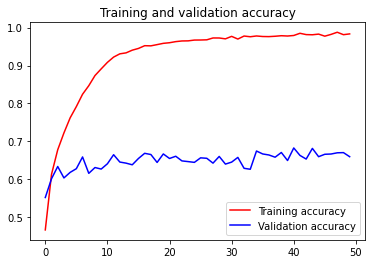

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [51]:
import seaborn as sn
def conf_matrix(dataset):
    real_labels = []
    pred_labels = []
    
    for splits, label in dataset:
        real_labels.append(label)
        pred_labels.append(predict_splits(splits))
    conf_m = tf.math.confusion_matrix(labels=real_labels, predictions=pred_labels )
    print(conf_m)
    genres = [LABEL_2_GENRE.get(i)[:3] for i in range(10)]
    df_cm = pd.DataFrame(conf_m, index=genres,
                  columns=genres, dtype=np.int8)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)    
    

tf.Tensor(
[[40  0  0  0  3  0  0  3  2 10]
 [ 0 58  0  0  4  0  0  0  0  0]
 [ 2  0 41  1  2  0  0  4  2  8]
 [ 3  2  1 37  8  0  2  0  1  2]
 [ 6  4  4  1 31  1  0  2  4  7]
 [ 0  0  0  0  0 59  0  0  0  0]
 [ 0  0  0  1  0  5 58  0  2  0]
 [ 3  0  0  0  0  0  0 44  0  1]
 [ 0  0  2  1  7  0  1  0 47  8]
 [16  0  1  1  2  0  0  2  3 36]], shape=(10, 10), dtype=int32)


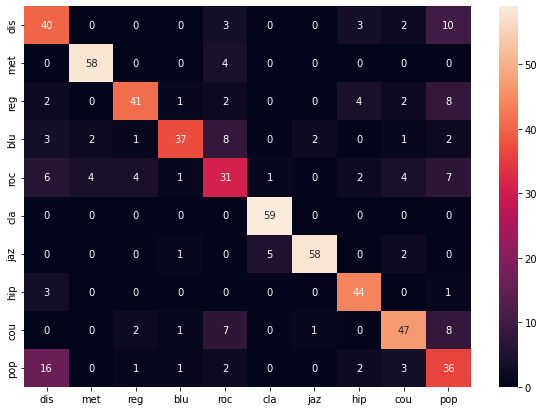

In [52]:
conf_matrix(test)

In [ ]:
model.save('/tmp/keras_model')

In [ ]:
import requests
from IPython import display
url = input()
r = requests.get(url, allow_redirects=True)
open('test.mp3', 'wb').write(r.content)

Y, sr = librosa.load('test.mp3')

display.Audio("test.mp3")

In [ ]:
splits = []

for split in split_track(Y):
    if len(split) == SAMPLES_PER_SPLIT:
        splits.append(preprocess_track(split))

print(np.array(splits).shape)
pred = model.predict(np.expand_dims(splits, axis=3))
#print(pred)
pred2 = pred.sum(axis=0)
print(pred2)
print(LABEL_2_GENRE)
print(LABEL_2_GENRE.get(np.argmax(pred2)))

